# San Diego Police Calls For Service

Eric Busboom, 7 Nov 2017

In preparation for the [SCALE and Open San Diego Crime ANalysis Presentation](https://www.eventbrite.com/e/exploring-san-diego-crime-data-using-python-workshop-tickets-39192959196?utm_source=eb_email&utm_medium=email&utm_campaign=reminder_attendees_48hour_email&utm_term=eventname), I downloaded the [data package for the presentation](https://drive.google.com/open?id=0B-sBXvhIZi_gWHJENGd2UkhWbVk) and started on the analysis a bit early. 

The presentation will use the San Diego Police 2015 calls for service, but the [data repository has 2016 and 2017 as well](https://data.sandiego.gov/datasets/police-calls-for-service/). The seperate files for each of the three years are converted into a data package on our repository, and I also created Metapack packages for the boundary files for beats, neighborhoods and districts. Merging in these boundary files allows for analysing crime counts by geography. Here are the packages: 

* [SD Police Calls For Service](http://data.sandiegodata.org/dataset/sandiego-gov-police_calls-2015e)
* [SD Police Beat, District Regions](http://data.sandiegodata.org/dataset/sandiego-gov-police_regions)
 
This notebook requires the metapack package for downloading URLS, which you should be able to install, on Python 3.5 or later, with ``pip install metapack``


In [1]:
%matplotlib inline
import metapack as mp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 

The Metapack system allows for packaging data, long with all of the metadata, and the ``open_package`` function can be used to load packages off the web. The the URL below is to a CSV package, which just referrs to CSV files on the web. You can get the link by to the CSV package file from the resource for ``sandiego.gov-police_regions-1`` in the [SRDRL data library repository page for the package](http://data.sandiegodata.org/dataset/sandiego-gov-police_regions)

In [2]:
regions = mp.open_package('http://library.metatab.org/sandiego.gov-police_regions-1.csv')
regions

After opening packages, we can ask the package for what resources it has, download those resources, and turn them into Pandas dataframes.

In [3]:
calls_p = mp.open_package('http://library.metatab.org/sandiego.gov-police_calls-2015e-1.csv')
calls_p

In [4]:
calls_r = calls_p.resource('pd_calls')
calls_r

Header,Type,Description
incident_num,text,Unique Incident Identifier
date_time,datetime,Date / Time in 24 Hour Format
day,integer,Day of the week
stno,integer,"Street Number of Incident, Abstracted to block level"
stdir1,text,Direction of street in address
street,text,Name of Street
streettype,text,Street Type
stdir2,text,"If intersecting street available, direction of that street"
stname2,text,"If intersecting street available, street name"
sttype2,text,"If intersecting street available, street type"


In [5]:
call_type_r = calls_p.resource('call_type')
call_types = call_type_r.dataframe().rename(columns={'description':'call_type_desc'})
call_types.head()

,call_type,call_type_desc
0,10,"OUT OF SERV, SUBJTOCALL"
1,10-97,ARRIVE ON SCENE
2,1016,PRISONER IN CUSTODY
3,1016PT,PTU (PRISONER TRANSPORT)
4,1016QC,SHOPLIFTER/QUICK CITE


In [6]:
regions_r = regions.resource('pd_beats')
regions_r

Header,Type,Description
id,integer,
objectid,integer,
beat,integer,
div,integer,
serv,integer,
name,text,
geometry,geometry,


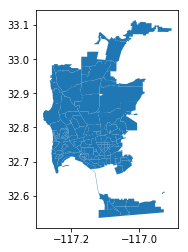

In [7]:
# The beats.cx[:-116.8,:] bit indexes the bounding box to exclude the empty portion of the 
# county. San Diego owns the footprint of a dam in east county, which displays as a tiny
# dot in the middle of empty space. 
# Note that this isn't actually defininf the bounding box; it's cutting out far-east regions, 
# and then GeoPandas creates the smaller bounding box that excludes them. So, the actually 
# value in the cx indexder can vary a bit. 

# Converting to float makes merging with the calls df ewasier, since the beat column
# in that df has nans. 

beats = regions_r.dataframe().geo
beats['beat'] = beats.beat.astype(float)
beats = beats.set_index('beat').cx[:-116.55,:]
beats.plot();

In [8]:
pd_calls = calls_r.read_csv(low_memory=False)
pd_calls.iloc[:5].T

,0,1,2,3,4
incident_num,P15010000001,P15010000002,P15010000003,P15010000004,P15010000005
date_time,2015-01-01 00:00:14,2015-01-01 00:00:30,2015-01-01 00:00:48,2015-01-01 00:00:57,2015-01-01 00:01:05
day,5,5,5,5,5
stno,3800,0,3600,0,3300
stdir1,NaN,NaN,NaN,NaN,NaN
street,DELTA,60TH,LOGAN,33RD,43RD
streettype,ST,ST,AV,ST,ST
stdir2,NaN,NaN,NaN,NaN,NaN
stname2,NaN,FEDERAL,NaN,IMPERIAL,NaN
sttype2,NaN,BL,NaN,AV,NaN


In [9]:
def augment_time(df):
    df['date_time'] = pd.to_datetime(df.date_time)
    
    df['hour'] = df.date_time.dt.hour
    df['month'] = df.date_time.dt.month
    df['year'] = df.date_time.dt.year
    df['dayofweek'] = df.date_time.dt.dayofweek
    df['weekofyear'] = df.date_time.dt.weekofyear

    df['weekofdata'] = (df.year-df.year.min())*52+df.date_time.dt.weekofyear
    df['monthofdata'] = (df.year-df.year.min())*12+df.date_time.dt.month

    return df

assert pd_calls.call_type.dtype == call_types.call_type.dtype

pd_calls = augment_time(pd_calls).merge(call_types, on='call_type')

pd_calls['beat'] = pd_calls.beat.astype(float)

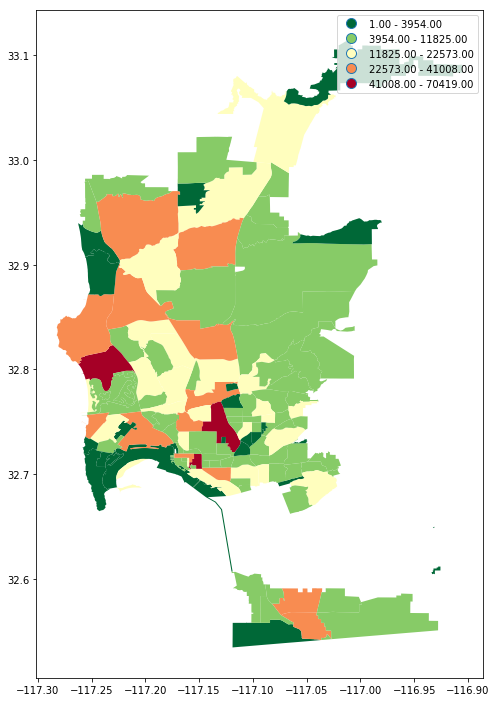

In [10]:

def plot_geo(df, color_col):
    # Need to get aspect right or it looks wacky
    bb = beats.total_bounds
    aspect = (bb[3] - bb[1])/ (bb[2]-bb[0])
    x_dim = 8

    fig = plt.figure(figsize = (x_dim,x_dim*aspect))
    ax = fig.add_subplot(111)

    df.plot(ax=ax,column=color_col, cmap='RdYlGn_r',
                     scheme='fisher_jenks', legend=True);
  
_ = gpd.GeoDataFrame(pd_calls.groupby('beat').incident_num.count().to_frame()\
                               .join(beats))

plot_geo(_, 'incident_num')

In [11]:
pd_calls.call_type_desc.value_counts().iloc[10:30]

FLAG DOWN/FIELD INITIATED         27573
REQUEST FOR TOW TRUCK             26614
NO DETAIL ACCIDENT                25611
FOLLOW-UP BY FIELD UNIT           25264
MENTAL CASE                       25146
SPECIAL DETAIL                    23887
SELECTIVE ENFORCEMENT             22891
HAZARDOUS CONDITION               22375
TRAFFIC STOP,FOR TMPOUT           20675
INFORMATION FOR DISPATCHERS       20645
SLEEPER                           20517
ALL UNITS INFORMATION-PRI 2       18598
LOUD PARTY                        17498
CAR THEFT REPORT                  16486
VEH VIOLATING 72HR PARKING RES    15911
CRIME CASE NUMBER REQUEST         15757
BATTERY                           15237
FOOT PATROL/FIELD INITIATED       14666
BURGLARY REPORT                   14362
RECKLESS DRIVING-ALL UNITS        14236
Name: call_type_desc, dtype: int64

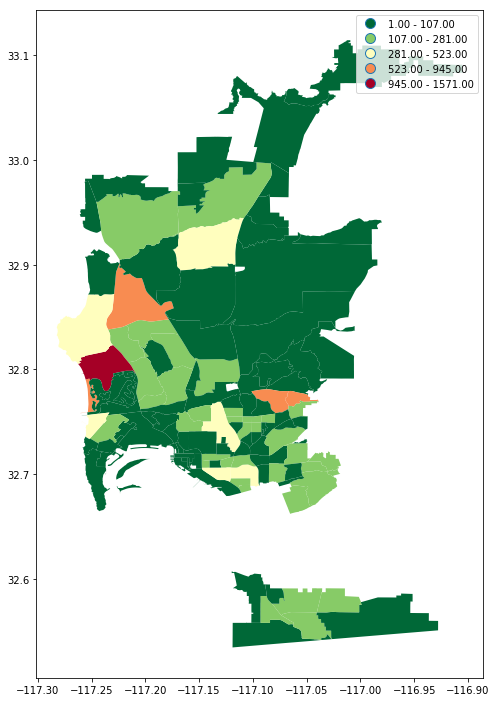

In [12]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'LOUD PARTY']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num')             

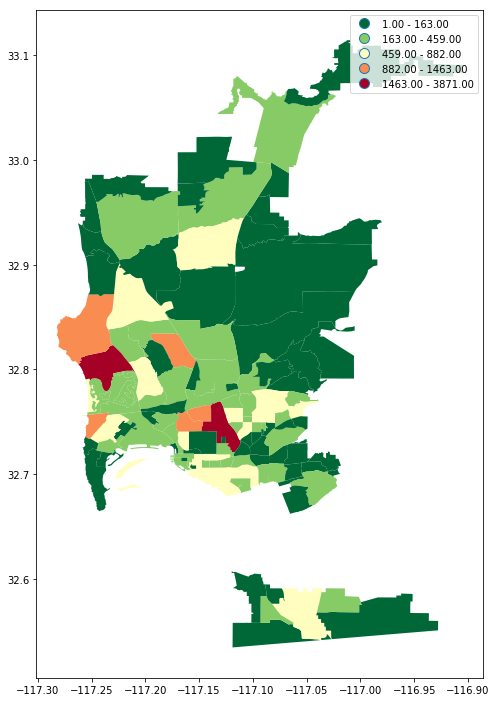

In [13]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'ILLEGAL PARKING']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num')  

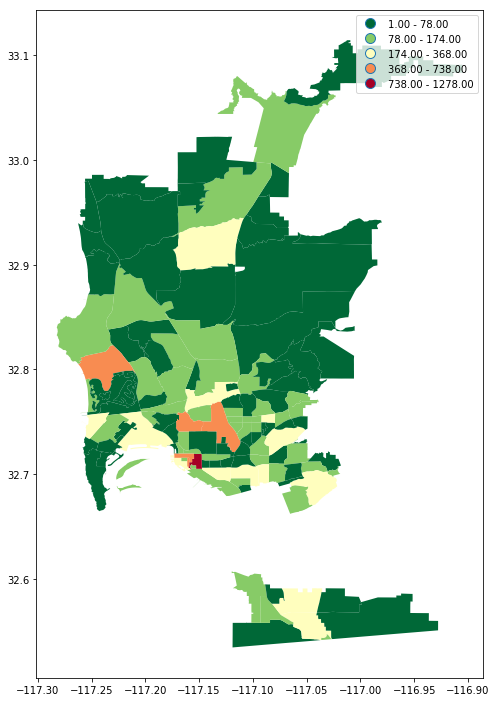

In [14]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'BATTERY']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num')  

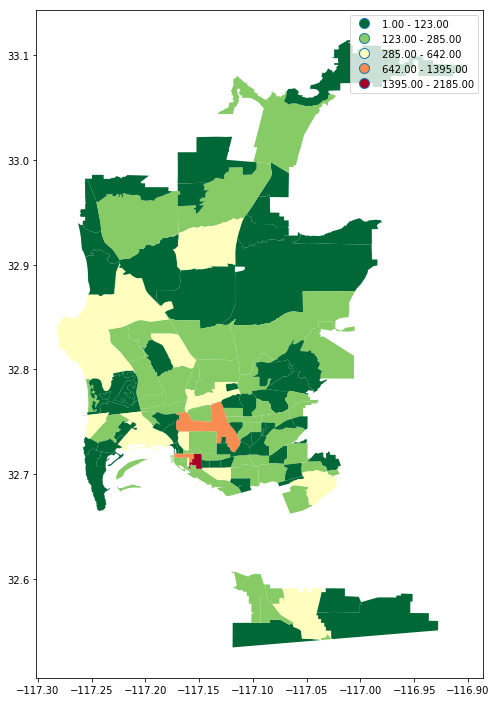

In [15]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'MENTAL CASE']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num') 